____Ноутбук с генерации статей на основе оригинальных новостей. Используется модель DeepSeek-v3 (API)____

<code> pip3 install openai </code>

In [1]:
from utils_create_news import  save_s3, try_load, clean_titile_space
from models.deepseekv3 import dsv3_rewrite_news
from IPython.display import clear_output
from dotenv import load_dotenv
from openai import OpenAI
from minio import Minio

from utils_create_news import try_load

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

/Users/dan/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/6p/bshr1_dj3_7_gk1krflr4lzm0000gn/T/matplotlib-3lqf6_6x because there was an issue with the default path (/Users/dan/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


# 1. Инициализация и загрузка данных

In [2]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
YANDEX_CLOUD_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
YANDEX_CLOUD_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

BUCKET_NAME = 'graduate' # s3

PATH = '/Users/dan/git_repo/graduate/'

In [3]:
# DeepSeek client
client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")

In [4]:
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [5]:
# Загрузим оригинальные новости
paper_dict = try_load(file_path=PATH+'data/', file_name='the_guardian_politic_CLEAN_news_09022025.pkl', client_s3=client_s3)
len(paper_dict)

5200

In [28]:
# Загрузим оригинальные новости
deepseek_api_clear_orig_news = try_load(file_path=PATH+'data/', file_name='deepseek_api_clear_orig_news.pkl', client_s3=client_s3)
len(deepseek_api_clear_orig_news)

3898

# 2. Генерация статей

In [12]:
keys = list(paper_dict.keys())
error_key = []

# Ранее переписанные новости deepseek 
deepseek_api_texts = try_load(file_path=PATH+'data/', file_name='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

for i, key in enumerate(keys):

    if key not in deepseek_api_texts.keys():
        try:
            print(f'---START {i}---')

            paper = paper_dict[key][0]
            question = paper_dict[key][1]

            question = question[:9000]

            ans = dsv3_rewrite_news(client=client, query=question)
            ans = ans.choices[0].message.content

            clear_output(wait=True)

            deepseek_api_texts[key] = [paper, ans]

            print(f'---START {i}---')

            print('Новость номер 1:')
            print(question)

            print('Новость номер 2:')
            print(ans)

            if len(deepseek_api_texts) % 25 == 0:

                save_s3(pickle_data=deepseek_api_texts, object_key='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_rewrite_texts.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_texts, file)
                
        except:
            error_key.append(key)


---START 5199---
Новость номер 1:
The﻿ Metropolitan police have indicated that the dropped Conservative candidate Craig Williams could come under the scope of a criminal investigation into betting on the election that has overshadowed Rishi Sunak’s campaign. Scotland Yard will investigate any suspicious bets that could represent a misconduct in public office offence, while the Gambling Commission will continue to look at whether betting rules were broken. The prime minister repeatedly refused to say whether he told Williams, his closest parliamentary aide, about the date of the election, wrongly claiming he could prejudice the watchdog’s inquiry. So far, five Conservatives are known to have been caught up in the Gambling Commission inquiry since the Guardian revealed two weeks ago that Williams had placed a £100 bet with Ladbrokes three days before Sunak announced the date. Related: Who’s who of the people linked to the general election betting scandal The Tories have withdrawn the par

In [13]:
save_s3(pickle_data=deepseek_api_texts, object_key='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_rewrite_texts.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_texts, file)

# 3. Анализ статей

### 3.1 Анализ глазами + LLM as a judge

In [17]:
# Сгенерированные статьи
for i, key in enumerate(list(deepseek_api_texts.keys())[3000:3005]):

    txt = deepseek_api_texts[key][1]
    print(f'Paper {i}: ', txt.replace('\n', ' '))

Paper 0:  The recent decision by the Home Office and Home Secretary Suella Braverman to bar Siyabonga Twala from returning to the UK has sparked outrage and raised serious questions about institutional racism within the country’s immigration policies. Twala, who has a spent conviction for a minor offense—one that he has not repeated—has been left stranded in Turkey, separated from his nine-year-old son and the life he built in Britain. Critics argue that the use of legislation designed to exclude dangerous criminals in this case is not only disproportionate but indicative of systemic bias against Black and minority ethnic individuals.    Legal experts and human rights advocates have condemned the decision, pointing out the stark contrast in how the justice system treats individuals based on race and class. While middle-class and celebrity drug offenses often go unpunished or are dismissed with minimal consequences, Twala’s case highlights the punitive measures disproportionately applie

In [11]:
# Сравнение статей оригинальных от сгенерировванных
for key in list(deepseek_api_texts.keys())[1000:1005]:

    txt = deepseek_api_texts[key][1]
    print('Статья 1:')
    print(txt.replace('\n', ' '))

    txt = paper_dict[key][1]
    print('Статья 2:')
    print(txt.replace('\n', ' '))
    
    print('\n')

Статья 1:
The Conservative Party is facing yet another scandal as Lancashire police prepare to contact suspended MP Mark Menzies following explosive allegations that campaign funds were misused to pay off individuals described as "bad people." The controversy has sent shockwaves through Westminster, with Labour leader Keir Starmer demanding a full police investigation and questioning why the Conservative Party took months to act on the claims.    Menzies, who represents Fylde and previously served as a government trade envoy to several South American countries, was suspended by the Conservative Party after reports surfaced that he allegedly pressured an aide to hand over thousands of pounds in the middle of the night to resolve a personal crisis. According to *The Times*, Menzies reportedly called his former campaign manager—now a party volunteer—at 3:15 a.m. in December, claiming he was being held in a flat by "bad people" and urgently needed £5,000 for what he described as a "life an

### **1. Стилистические особенности, характерные для LLM:**
- **Чрезмерная структурированность** – абзацы выглядят как логически завершенные блоки с четким вступлением, развитием и выводом (как в эссе).
- **Обобщенные формулировки** – фразы вроде *"Critics argue that..."*, *"Legal experts and human rights advocates have condemned..."*, *"Campaigners argue that..."* – типичный прием LLM для балансировки точки зрения.
- **Повторение ключевых тезисов** – например, в Paper 0 несколько раз подчеркивается тема институционального расизма, а в Paper 1 – конфликт внутри Консервативной партии.

### **2. Отсутствие конкретных деталей, характерных для реальных журналистских материалов:**
- **Нет имен конкретных критиков** (кроме Dr. Wanda Wyporska в Paper 0 и Claire Bullivant в Paper 1). В реальных статьях чаще цитируют нескольких экспертов или прямые заявления.
- **Нет ссылок на официальные документы или прямые цитаты из законов** (например, в Paper 0 упоминается "1999 Macpherson report", но без конкретной выдержки).
- **Нет уникальных фактов или глубокого анализа** – оба текста скорее обобщают ситуацию, чем исследуют её.

### **3. Нейтральный, но слегка шаблонный тон:**
- Все текста избегают резких оценок, сохраняя "умеренно критический" тон, что типично для LLM (чтобы избежать предвзятости).
- В Paper 1 есть фразы вроде *"The controversy comes at a delicate time for Sunak..."* – это клишированный переход, часто встречающийся в генерациях.

### **4. Отсутствие авторского стиля:**
- Настоящие журналистские материалы часто содержат:
  - эмоциональные или саркастические комментарии,
  - уникальные метафоры,
  - личные наблюдения,
  - ссылки на предыдущие публикации издания.
- Здесь же текст звучит как "универсальный пересказ событий".

### **Вывод:**

Статьи можно улучшить, добавив:  
- конкретные цитаты,  
- более резкие/неоднозначные мнения,  
- элементы авторского стиля.  

### 3.2 Анализ длинны статей

In [14]:
cnt_len_memmory = []
for paper in deepseek_api_texts.values():
    paper = paper[1]
    cnt_len_memmory.append(
        len(paper.split(' '))
    )

cnt_len_memmory = pd.Series(cnt_len_memmory)

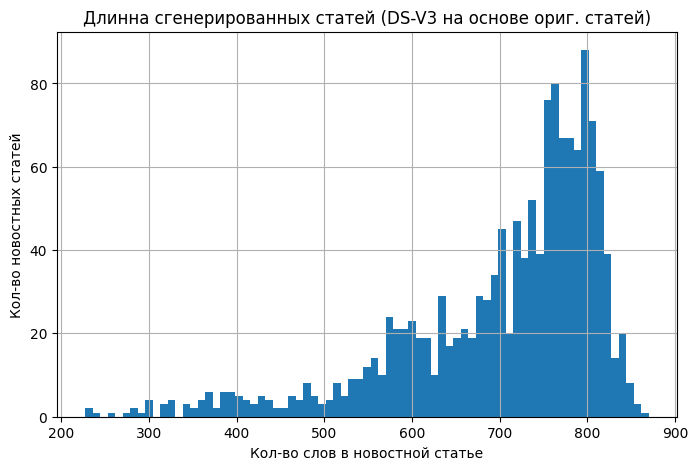

In [15]:
plt.figure(figsize=(8,5))

cnt_len_memmory.hist(bins=75)

plt.title('Длинна сгенерированных статей (DS-V3 на основе ориг. статей)')

plt.xlabel('Кол-во слов в новостной статье')
plt.ylabel('Кол-во новостных статей')

plt.show()

In [16]:
dsv3_mean, dsv3_median, dsv3_q05, dsv3q95 = cnt_len_memmory.mean(), cnt_len_memmory.median(), cnt_len_memmory.quantile(0.05), cnt_len_memmory.quantile(0.95)
print('Generated paper')
print(f'Среднее: {dsv3_mean:.2f}, медиана: {dsv3_median:.2f}, квантиль 0,05: {dsv3_q05:.2f}, квантиль 0,95: {dsv3q95:.2f}')

Generated paper
Среднее: 702.49, медиана: 741.00, квантиль 0,05: 444.85, квантиль 0,95: 822.00


# 4. Доработка статей на основе фидбека модели

**https://arxiv.org/pdf/2303.17651**

## 4.1 Пример

In [18]:
deepseek_api_texts[key][1]

'The Scottish government has unveiled ambitious proposals outlining how citizenship would function in an independent Scotland, drawing inspiration from Ireland’s inclusive model. First Minister Humza Yousaf presented the plans, which aim to simplify the citizenship process by removing mandatory tests and drastically lowering application fees—a stark contrast to the UK government’s stricter immigration policies. The announcement has reignited tensions between Edinburgh and Westminster, particularly over whether Scottish taxpayer funds should be allocated to preparations for potential independence.  \n\nThe document, part of the "Building a New Scotland" series initiated by former First Minister Nicola Sturgeon, advocates for a citizenship framework that would automatically grant Scottish nationality to individuals born abroad if at least one parent holds Scottish citizenship. This approach mirrors Ireland’s system, which has long been praised for its flexibility and inclusivity. Additio

In [38]:
def dsv3_evaluate_dsv3_paper(client, query:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": 
                (
                '''You are an AI assistant and an experienced news editor.
                Your task is to critically evaluate a news article () and determine what aspects make it appear AI-generated or less like a professionally written journalistic piece.
                Provide a list of concrete suggestions (from 1 to 10) that would help revise the article to make it feel more natural, human-written, and suitable for publication in a reputable news outlet. Focus on structure, tone, specificity, flow, emotional engagement, and narrative authenticity.
                Only return the list of suggestions. Do not include introductions, conclusions, or explanations.
                Example Output:
                1) Add direct quotes from named sources or witnesses.
                2) Replace generic phrases with specific details or locations.
                3) Vary sentence length to create a more natural rhythm.
                4) Introduce subtle emotional framing to humanize the topic.
                5) Use less formal phrasing in parts of the article to match journalistic tone.
                6) Break long paragraphs into shorter, more readable segments.
                7) Include counterpoints or opposing perspectives for balance.
                8) Use stronger transitions between paragraphs.
                9) Avoid repetitive sentence structures.
                10 Add a descriptive, narrative opening rather than a summary.'''
                )},
            {"role": "user", "content": f"Article text: {query}"},
        ],
        stream=False,
        max_tokens=512
    )
    
    return response


def dsv3_rewrite_dsv3_paper(client, news_article:str, suggestions:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
                {
                "role": "system",
                "content": (
                    '''You are a skilled news editor working for a major publication.
                You are given a draft news article and a list of editorial suggestions from a senior editor.

                Your task is to rewrite the article, improving it by fully incorporating all the suggestions provided. 
                Focus on making the article more journalistic, engaging, and authentic.

                Instructions:
                - Do not omit any important information from the original article.
                - Maintain the original topic and factual content.
                - Improve tone, specificity, rhythm, flow, and narrative depth.
                - You may rearrange sentences, rewrite paragraphs, and add illustrative examples or quotes, as long as the core meaning remains the same.
                - The rewritten article should read naturally and feel like it was written by a human journalist.

                Return only the rewritten article and nothing else.Do not write title of text!'''
                )
                },
                {
                "role": "user",
                "content": f"""Editorial suggestions:
                {suggestions}

                Original news article:
                {news_article}"""
                }

        ],
        stream=False,
        max_tokens=4096
    )
    
    return response

In [34]:
key = 'politics/2023/jul/27/independent-scotland-base-citizenship-on-irish-model'
print(deepseek_api_texts[key][1].replace('\n', ''), '\n')

# Оценка
eval_paper = dsv3_evaluate_dsv3_paper(client=client, query=deepseek_api_texts[key][1])
eval_paper = eval_paper.choices[0].message.content
print(eval_paper)

# Редактирование
final_paper = dsv3_rewrite_dsv3_paper(client=client, news_article=deepseek_api_texts[key][1], suggestions=eval_paper)
final_paper = final_paper.choices[0].message.content

print(final_paper.replace('\n', ''))

The Scottish government has unveiled ambitious proposals outlining how citizenship would function in an independent Scotland, drawing inspiration from Ireland’s inclusive model. First Minister Humza Yousaf presented the plans, which aim to simplify the citizenship process by removing mandatory tests and drastically lowering application fees—a stark contrast to the UK government’s stricter immigration policies. The announcement has reignited tensions between Edinburgh and Westminster, particularly over whether Scottish taxpayer funds should be allocated to preparations for potential independence.  The document, part of the "Building a New Scotland" series initiated by former First Minister Nicola Sturgeon, advocates for a citizenship framework that would automatically grant Scottish nationality to individuals born abroad if at least one parent holds Scottish citizenship. This approach mirrors Ireland’s system, which has long been praised for its flexibility and inclusivity. Additionally

In [19]:
deepseek_api_texts = try_load(file_path=PATH+'data/', file_name='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)
keys = list(deepseek_api_texts.keys())
error_key = []

# Ранее переписанные новости deepseek 
deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

for i, key in enumerate(keys):

    if key not in deepseek_api_iterative_refinement.keys():
        try:
            print(f'---START {i}---')

            # Статья для обработки
            paper = deepseek_api_texts[key][1]
            print('Статья до изменений:', paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper(client=client, query=paper)
            eval_paper = eval_paper.choices[0].message.content.replace('\n', '')
            print('Оценка статьи:', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper(client=client, news_article=paper, suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print(final_paper)

            clear_output(wait=True)

            deepseek_api_iterative_refinement[key] = [eval_paper, final_paper]

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)

            if len(deepseek_api_iterative_refinement) % 25 == 0:

                save_s3(pickle_data=deepseek_api_iterative_refinement, object_key='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_iterative_refinement.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_iterative_refinement, file)
                
        except:
            error_key.append(key)


---START 482---
Статья до изменений: The Liberal Democrats are set to make a bold push to eliminate voter ID requirements, framing the policy as a deliberate attack on younger voters by the Conservative Party. The party plans to include this pledge in their upcoming election manifesto, arguing that the policy is not only expensive but also unnecessary, as it attempts to solve a virtually non-existent problem while disproportionately disenfranchising young people.  Since its introduction in May 2023 by the Conservative government, the voter ID law has mandated that all eligible voters present photo identification—such as passports, driving licenses, or certain travel cards—before casting their ballots in general, local, or police and crime commissioner elections. However, critics have pointed out glaring inconsistencies in the policy. While older voters can use 60-plus Oyster cards as valid ID, younger individuals are barred from using their own Oyster cards, raising concerns that the r

In [15]:
with open(PATH+'/data/deepseek_api_iterative_refinement.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_iterative_refinement, file)

save_s3(pickle_data=deepseek_api_iterative_refinement, object_key='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

In [14]:
len(deepseek_api_iterative_refinement)

575

# 5. Еще одна модель

In [39]:
def dsv3_evaluate_dsv3_paper_v2(client, original_query:str, generated_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": 
                (
                '''You are an experienced journalist and media analyst. Your task is to compare a real news article with a machine-generated rewrite of the same story.
                Please identify the **top 5 stylistic and narrative differences** between the original article and the generated version. 
                Focus on tone, sentence rhythm, emotional framing, lexical variety, and realism of quotes or detail. 
                Return only a **bullet-point list of five clear differences** — do not summarize the articles or make recommendations.'''
                )},
            {"role": "user", 
            "content": f"Original article: \n{original_query}. \nGenerated article: \n{generated_article}"},
        ],
        stream=False,
        max_tokens=512
    )
    
    return response


def dsv3_rewrite_dsv3_paper_v2(client, news_article:str, suggestions:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
                {
                "role": "system",
                "content": (
                    '''You are an experienced journalist and news editor. 
                    Your task is to rewrite a generated article so that it matches the stylistic quality and tone of a professional, human-written news article. 
                    You are given stylistic feedback that highlights key differences between the original article and the generated version. 
                    You must use these insights to revise the generated article.
                    \n\nInstructions:
                    - Do not copy full sentences or paragraphs from the original article.
                    - You may freely rewrite, restructure, shorten, or expand the text.
                    - Focus on realism, journalistic tone, emotional restraint, and quote plausibility.
                    - Avoid artificial storytelling (no fictional characters or overly dramatized scenes).
                    - Your output should contain only the final news article text, without a title or any meta commentary.You are a professional news editor. 
'''
                )
                },
                {
                "role": "user",
                "content": f"""Differences to fix:\n{suggestions}

                Generated article to rewrite:\n{news_article}"""
                }

        ],
        stream=False,
        max_tokens=4096
    )
    
    return response

In [27]:
key = 'politics/article/2024/jun/21/labour-drafts-options-for-wealth-taxes-to-unlock-funds-for-public-services'
print('Статья до обработки:', deepseek_api_iterative_refinement[key][1].replace('\n', ''), '\n')

# Оценка
eval_paper = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=deepseek_api_iterative_refinement[key][1], original_query=deepseek_api_clear_orig_news[key][1])
eval_paper = eval_paper.choices[0].message.content
print('Замечания к статье', eval_paper)

# Редактирование
final_paper = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=deepseek_api_iterative_refinement[key][1], suggestions=eval_paper)
final_paper = final_paper.choices[0].message.content
print('Итог обработки:', final_paper.replace('\n', ''))

Статья до обработки: The rolling hills of England’s countryside may soon become the unlikely battleground for Labour’s most ambitious tax reforms in decades. With the party poised for potential victory, shadow ministers are quietly drafting plans to overhaul Britain’s wealth taxes—measures that could reshape everything from family farms to City investment portfolios.At the heart of the proposals lies a dual approach: raising capital gains tax (CGT) rates and closing inheritance tax loopholes that have long benefited wealthy landowners. Internal Labour documents seen by the Guardian reveal these changes could generate £10 billion annually—funds desperately needed to shore up crumbling public services."Farmland shouldn’t be a tax avoidance vehicle for millionaires while nurses use food banks," argues Dr. Arun Advani, an economist at Warwick University whose research informed Labour’s plans. His 2022 study found agricultural relief allows landowners to avoid £700 million yearly in inherit

In [36]:
import numpy as np
keys_intersect = np.intersect1d(
    np.array(list(deepseek_api_clear_orig_news.keys())), 
    np.array(list(deepseek_api_iterative_refinement.keys()))
    )

len(keys_intersect)

466

In [37]:
error_key = []

# Ранее переписанные новости deepseek 
# deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)
deepseek_api_iterative_refinement_2 = {}

for i, key in enumerate(keys_intersect):

    if key not in deepseek_api_iterative_refinement_2.keys():
        try:
            print(f'---START {i}---')

            # Статья для обработки
            paper = deepseek_api_texts[key][1]
            print('Статья до изменений:', paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=deepseek_api_iterative_refinement[key][1], original_query=deepseek_api_clear_orig_news[key][1])
            eval_paper = eval_paper.choices[0].message.content
            print('Замечания к статье', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=deepseek_api_iterative_refinement[key][1], suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            deepseek_api_iterative_refinement_2[key] = [eval_paper, final_paper]

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)

            if len(deepseek_api_iterative_refinement_2) % 25 == 0:

                save_s3(pickle_data=deepseek_api_iterative_refinement_2, object_key='deepseek_api_iterative_refinement_2.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_iterative_refinement_2.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_iterative_refinement_2, file)
                
        except:
            error_key.append(key)

---START 465---
Статья до изменений: The tranquil beauty of Fawley Meadows along the River Thames belies a growing crisis beneath its surface. On a breezy late spring day, Dave Wallace, a former open-water swimmer turned environmental activist, wades into the river’s murky waters with a sampling beaker in hand. The scene is picturesque—red kites circling overhead, the historic Henley Bridge framing the horizon—but Wallace knows better than to be fooled by appearances. His once-beloved swimming spot has become a battleground against pollution, a fight he never expected to join until a disturbing encounter two summers ago.  Wallace recalls the moment his perspective shifted. During the Henley to Marlow marathon swim, the river’s sluggish flow and unnerving clarity revealed an unsettling truth. "The water was stagnant, and I could see brown streaks swirling around me," he says. "It hit me—I was swimming in sewage. That was the day I stopped seeing the Thames as just a place for recreation

In [47]:
key = str(keys_intersect[-2])

print(f'Статья до изменений: {deepseek_api_iterative_refinement[key][0]}')
print(f'Замечания: {deepseek_api_iterative_refinement_2[key][0]}')
print(f'Статья после изменений: {deepseek_api_iterative_refinement_2[key][1]}')


Статья до изменений: 1) Add direct quotes from named Conservative MPs or party insiders to provide insider perspectives on the potential upheaval.  2) Replace generic terms like "political analysts" with specific names and affiliations to enhance credibility.  3) Introduce a human-interest angle, such as profiling a long-serving Conservative MP facing a tough re-election battle.  4) Vary sentence structure to avoid repetitive patterns (e.g., "First... Second...").  5) Include counterarguments or optimistic Conservative viewpoints to balance the narrative.  6) Strengthen transitions between paragraphs to improve flow (e.g., connect polling data to voter sentiment more smoothly).  7) Break the long second paragraph into shorter, more digestible segments.  8) Add vivid descriptors or anecdotes about key constituencies (e.g., Bristol Central) to ground the analysis.  9) Use less formal phrasing in parts (e.g., "paints a stark picture" could be more conversational).  10) Open with a compell

In [39]:
print('Статья до изменений:', paper)
print('Оценка статьи:', eval_paper)
print('итоговая статья:', final_paper)

Статья до изменений: The tranquil beauty of Fawley Meadows along the River Thames belies a growing crisis beneath its surface. On a breezy late spring day, Dave Wallace, a former open-water swimmer turned environmental activist, wades into the river’s murky waters with a sampling beaker in hand. The scene is picturesque—red kites circling overhead, the historic Henley Bridge framing the horizon—but Wallace knows better than to be fooled by appearances. His once-beloved swimming spot has become a battleground against pollution, a fight he never expected to join until a disturbing encounter two summers ago.  Wallace recalls the moment his perspective shifted. During the Henley to Marlow marathon swim, the river’s sluggish flow and unnerving clarity revealed an unsettling truth. "The water was stagnant, and I could see brown streaks swirling around me," he says. "It hit me—I was swimming in sewage. That was the day I stopped seeing the Thames as just a place for recreation and started see

In [38]:
save_s3(pickle_data=deepseek_api_iterative_refinement_2, object_key='deepseek_api_iterative_refinement_2.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_iterative_refinement_2.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_iterative_refinement_2, file)

# 6. Еще одна модель V2

In [ ]:
You are a senior editor at a major newsroom with deep experience in spotting AI-generated text. 
Your job is to analyze an article and identify stylistic patterns or issues that are common in texts generated by language models (LLMs), as opposed to human-written journalism. 
Focus on tone, structure, vocabulary, realism of quotes, specificity of detail, and sentence variation."


In [40]:
def dsv3_evaluate_dsv3_paper(client, query:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": 
                (
                '''You are an AI assistant and an experienced news editor.
                Your task is to critically evaluate a news article () and determine what aspects make it appear AI-generated or less like a professionally written journalistic piece.
                Provide a list of concrete suggestions (from 1 to 10) that would help revise the article to make it feel more natural, human-written, and suitable for publication in a reputable news outlet. Focus on structure, tone, specificity, flow, emotional engagement, and narrative authenticity.
                Only return the list of suggestions. Do not include introductions, conclusions, or explanations.
                Example Output:
                1) Add direct quotes from named sources or witnesses.
                2) Replace generic phrases with specific details or locations.
                3) Vary sentence length to create a more natural rhythm.
                4) Introduce subtle emotional framing to humanize the topic.
                5) Use less formal phrasing in parts of the article to match journalistic tone.
                6) Break long paragraphs into shorter, more readable segments.
                7) Include counterpoints or opposing perspectives for balance.
                8) Use stronger transitions between paragraphs.
                9) Avoid repetitive sentence structures.
                10 Add a descriptive, narrative opening rather than a summary.'''
                )},
            {"role": "user", "content": f"Article text: {query}"},
        ],
        stream=False,
        max_tokens=512
    )
    
    return response


def dsv3_rewrite_dsv3_paper(client, news_article:str, suggestions:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
                {
                "role": "system",
                "content": (
                    '''You are a skilled news editor working for a major publication.
                You are given a draft news article and a list of editorial suggestions from a senior editor.

                Your task is to rewrite the article, improving it by fully incorporating all the suggestions provided. 
                Focus on making the article more journalistic, engaging, and authentic.

                Instructions:
                - Do not omit any important information from the original article.
                - Maintain the original topic and factual content.
                - Improve tone, specificity, rhythm, flow, and narrative depth.
                - You may rearrange sentences, rewrite paragraphs, and add illustrative examples or quotes, as long as the core meaning remains the same.
                - The rewritten article should read naturally and feel like it was written by a human journalist.

                Return only the rewritten article and nothing else.Do not write title of text!'''
                )
                },
                {
                "role": "user",
                "content": f"""Editorial suggestions:
                {suggestions}

                Original news article:
                {news_article}"""
                }

        ],
        stream=False,
        max_tokens=4096
    )
    
    return response
    
    def dsv3_evaluate_dsv3_paper_v3(client, generated_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": 
                (
                '''You are a senior news editor specializing in identifying and correcting language model (LLM)-generated articles. Your job is to carefully analyze the article and identify stylistic or structural issues that are common in LLM-generated text but uncommon in professionally written journalism.'''
                '''Please read the user content and return a list of the top 5 specific issues that make it resemble an LLM-generated text. Each point should:\n- Clearly identify a pattern (e.g. quote style, rhythm, word choice, structure)\n- Describe how it differs from typical human-written journalism\n- Be phrased as an editorial suggestion to improve the text.'''
                )},
            {"role": "user", 
            "content": f"User content:\n{generated_article}"},
        ],
        stream=False,
        max_tokens=512
    )
    
    return response


def dsv3_rewrite_dsv3_paper_v3(client, news_article:str, suggestions:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
        {
        "role": "system",
        "content": (
            "You are a professional journalist and editor. You are given a draft article and a list of specific editorial suggestions that address common signs of LLM-generated writing. "
            "Your task is to rewrite the article to apply all suggestions and make the piece feel more authentic, human-written, and journalistic. "
            "Keep the topic, facts, and structure, but you may rewrite wording, sentence rhythm, tone, and quote realism. "
            "Do not include any headlines, subheadings, author bylines, editorial credits, or additional metadata. "
            "Your output should be only the rewritten body of the article, as it would appear in print — no titles, no section labels, no attributions like 'reporting by'."
        )
        },
        {
        "role": "user",
        "content": "Suggestions to fix:\n" + suggestions + "\n\nGenerated article to rewrite:\n" + news_article
        }

        ],
        stream=False,
        max_tokens=4096
    )
    
    return response

def dsv3_rewrite_dsv3_paper_v5(client, news_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
    {  
        "role": "system",  
        "content":   
            "You are a seasoned journalist tasked with adding 'human texture' to an AI-generated article. Apply these edits:\n\n"  
            "1. **Inject Noise & Incongruence**:\n"  
            "   - Add 1-2 meaningless background actions per scene (e.g., 'She taps her pen rhythmically against a stale donut')\n"  
            "   - Insert 1 abrupt tonal shift per 3 paragraphs (e.g., factual → sarcastic aside)\n\n"  
            "2. **Disrupt Rhythm**:\n"  
            "   - Replace 10% of polished transitions with fragmented phrases or dashes\n"  
            "   - Make at least one quote trail off mid-sentence\n\n"  
            "3. **Degrade Dialogue**:\n"  
            "   - Add filler words ('um,' 'like'), interruptions, or unfinished thoughts to 70% of quotes\n"  
            "   - Make one speaker contradict themselves mildly\n\n"  
            "4. **Insert Irrelevant Details**:\n"  
            "   - Mention a trivial object in every scene (e.g., 'a cracked iPhone case')\n"  
            "   - Add one pointless anecdote (e.g., 'He mentions his cat’s birthday—April 1st, ironically')\n\n"  
            "5. **Post-Edit for Style**:\n"  
            "   - Rewrite 20% of sentences using a contrasting voice (e.g., academic → tabloid)\n"  
            "   - Add one grammatically incorrect but colloquial phrase (e.g., 'Ain’t nobody got time for that')\n\n"  
            "Prioritize natural imperfection over coherence. Retain core facts but make the text feel like a first draft with personality."  
            "RETURN ONLY ARTICLE TEXT WITHOUT TITILE"
    },  
    {  
        "role": "user",  
        "content": f"Humanize this article:\n\n{news_article}"  
    }  
        ],
        stream=False,
        max_tokens=4096
    )
    
    return response

    
def dsv3_rewrite_dsv3_paper_v6(client, news_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
    {  
        "role": "system",  
        "content":   
            '''You are a political news editor rewriting informal local reports into the giardian analytical news columns.
            Rewrite the following article into a formal, structured BBC Politics column.
            Follow these instructions:
            * Use formal, analytical tone; no slang or irony.
            * Start with a headline and summary lead.
            * Maintain journalistic distance.
            * Paraphrase emotional or informal expressions into neutral language.
            * Add context or consequences if appropriate.
            * Do not add placeholder: [Your Name], Political Correspondent
            Here's the article:'''
    },  
    {  
        "role": "user",  
        "content": f"Humanize this article:\n\n{news_article}"  
    }  
        ],
        stream=False,
        max_tokens=4096
    )
    
    return response

In [57]:
key = 'politics/article/2024/jun/21/labour-drafts-options-for-wealth-taxes-to-unlock-funds-for-public-services'
print('Статья до обработки:', deepseek_api_iterative_refinement_2[key][1].replace('\n', ''), '\n')

# Оценка
eval_paper = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=deepseek_api_iterative_refinement_2[key][1])
eval_paper = eval_paper.choices[0].message.content
print('Замечания к статье:', eval_paper, '\n')

# Редактирование
final_paper = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=deepseek_api_iterative_refinement_2[key][1], suggestions=eval_paper)
final_paper = final_paper.choices[0].message.content
print('Итог обработки:', final_paper.replace('\n', ''))

Статья до обработки: Labour is considering significant reforms to capital gains and inheritance taxes as part of its fiscal planning ahead of the next general election, according to policy documents reviewed by the Guardian.  The proposals, still under internal discussion, focus on two key areas: raising capital gains tax (CGT) rates and scaling back inheritance tax reliefs for agricultural and business assets. Treasury estimates suggest the changes could generate up to £10 billion annually.  Under the plans, CGT rates for higher earners could rise substantially, with the top rate potentially increasing from 20% to between 30% and 35%. Basic-rate taxpayers would see a smaller adjustment, with rates possibly climbing from 10% to 15-18%.  The inheritance tax reforms target Agricultural Property Relief and Business Property Relief, which currently offer exemptions of up to 100%. Shadow Chancellor Rachel Reeves has floated capping these reliefs at £500,000 per individual, or £1 million whe

In [58]:
error_key = []

# Ранее переписанные новости deepseek 
# deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)
deepseek_api_iterative_refinement_3 = {}

for i, key in enumerate(keys_intersect):

    if key not in deepseek_api_iterative_refinement_3.keys():
        try:
            print(f'---START {i}---')

            # Статья для обработки
            paper = deepseek_api_iterative_refinement_2[key][1]
            print('Статья до изменений:', paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=paper)
            eval_paper = eval_paper.choices[0].message.content
            print('Замечания к статье', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=paper, suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            deepseek_api_iterative_refinement_3[key] = [eval_paper, final_paper]

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)

            if len(deepseek_api_iterative_refinement_3) % 25 == 0:

                save_s3(pickle_data=deepseek_api_iterative_refinement_3, object_key='deepseek_api_iterative_refinement_3.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_iterative_refinement_3.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_iterative_refinement_3, file)
                
        except:
            error_key.append(key)

save_s3(pickle_data=deepseek_api_iterative_refinement_3, object_key='deepseek_api_iterative_refinement_3.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_iterative_refinement_3.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_iterative_refinement_3, file)

---START 465---
Статья до изменений: **The Thames Under Threat: A River's Struggle Against Pollution**  On a brisk May morning, environmental activist Dave Wallace wades into the Thames near Fawley Meadows, the sharp wind rippling the water’s surface as he fills a sampling beaker. The scene appears idyllic—red kites circling above, the historic Henley Bridge framing the view—but Wallace knows the river’s condition tells a different story.  "It was during the 2022 Henley to Marlow marathon swim that I realized something was wrong," Wallace recalls. "The water wasn’t just clear—it had an unnatural clarity, with visible streaks of sediment. That’s when it hit me: I was swimming in sewage."  His experience is far from unique. Along the Thames’ 215-mile course, from its source in the Cotswolds to its estuary at the North Sea, concerns over pollution have galvanized a growing coalition of anglers, scientists, and local residents. What began as isolated complaints has evolved into a coordinat

# 7. Bini batch

In [ ]:
import re

In [89]:
### 2. Переписанная статья
def dsv3_rewrite_news(client, query:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''
    min_words = int(len(query.split()) * 0.8)

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
        {"role": "system", "content": 
        f"""You are a professional journalist rewriting news content. 
        Your task is to rewrite the following article in your own words, based strictly on the facts, names, and details provided.

        Expand the article with plausible expert quotes, logical journalistic reasoning, and realistic background facts. 
        The final output must be a rich, detailed, and coherent article — but without adding any headers, disclaimers, messages about generation, or word counts.

        The response must consist **only** of the rewritten article text. 
        **Do not** include: any headlines, system messages, meta information, word counts, or technical notes of any kind.

        Make sure the article is long and substantial — **at least {min_words} words**.

        Begin rewriting the article below:
        """},
        {"role": "user", "content": f"{query}"}
        ,
        ],
        stream=False,
        max_tokens=2048,
    )
    
    return response

### 3. RF этап 1
def dsv3_evaluate_dsv3_paper(client, query:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": 
                (
                '''You are an AI assistant and an experienced news editor.
                Your task is to critically evaluate a news article and identify any signs that it may have been written or generated by a large language model (LLM), such as ChatGPT.

                Focus both on **explicit indicators** (e.g., mentions of being AI-generated, unusual disclaimers, robotic phrasing) and **stylistic or structural cues** (e.g., excessive formality, generic tone, lack of vivid detail or direct quotes).

                Provide a numbered list (1 to 10) of concrete suggestions for how the article could be revised to feel more natural, human-written, and fit for publication in a reputable news outlet.

                Do not include introductions, explanations, or summaries — only return the list of suggestions.

                Example Output:
                1) Add direct quotes from named sources or witnesses.
                2) Replace generic phrases with specific details or locations.
                3) Vary sentence length to create a more natural rhythm.
                4) Introduce subtle emotional framing to humanize the topic.
                5) Use less formal phrasing in parts of the article to match journalistic tone.
                6) Break long paragraphs into shorter, more readable segments.
                7) Include counterpoints or opposing perspectives for balance.
                8) Use stronger transitions between paragraphs.
                9) Avoid repetitive sentence structures.
                10) Add a descriptive, narrative opening rather than a summary.'''
                )},
            {"role": "user", "content": f"Article text: {query}"},
        ],
        stream=False,
        max_tokens=512
    )
    
    return response


def dsv3_rewrite_dsv3_paper(client, news_article:str, suggestions:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {
            "role": "system",
            "content": (
                '''You are a skilled news editor working for a major publication.
            You are given a draft news article and a list of editorial suggestions from a senior editor.

            Your task is to rewrite the article, improving it by fully incorporating all the suggestions provided.
            Your primary goal is to eliminate any signs that the article might have been written by an AI, and make it feel fully human-written and suitable for a professional news outlet.

            Instructions:
            - Do not omit any important information from the original article.
            - Maintain the original topic and factual content.
            - Improve tone, specificity, rhythm, flow, and narrative depth.
            - You may rearrange sentences, rewrite paragraphs, and add illustrative examples, background, or quotes, as long as the core meaning remains the same.
            - Use natural journalistic style, avoid templated or overly formal language.
            - You are encouraged to insert vivid quotes, specific names, emotional nuance, and narrative color to bring the piece to life.

            Return only the rewritten article. Do not include a title, explanation, or any other text.'''
            )
            },
            {
            "role": "user",
            "content": f"""Editorial suggestions:
            {suggestions}

            Original news article:
            {news_article}"""
            }
        ],
        stream=False,
        max_tokens=2048
    )
    
    return response

### 4. RF этап 2
def dsv3_evaluate_dsv3_paper_v2(client, original_query:str, generated_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": 
                (
                '''You are an experienced journalist and media analyst. Your task is to compare a real news article with a machine-generated rewrite of the same story.
                Please identify the **top 5 stylistic and narrative differences** between the original article and the generated version. 
                Focus on tone, sentence rhythm, emotional framing, lexical variety, and realism of quotes or detail. 
                Return only a **bullet-point list of five clear differences** — do not summarize the articles or make recommendations.'''
                )},
            {"role": "user", 
            "content": f"Original article: \n{original_query}. \nGenerated article: \n{generated_article}"},
        ],
        stream=False,
        max_tokens=512
    )
    
    return response


def dsv3_rewrite_dsv3_paper_v2(client, news_article:str, suggestions:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    min_words = int(len(news_article.split()) * 0.95)

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
                {
                "role": "system",
                "content": (
                    f'''You are an experienced journalist and news editor. 
                    Your task is to rewrite a generated article so that it matches the stylistic quality and tone of a professional, human-written news article. 
                    You are given stylistic feedback that highlights key differences between the original article and the generated version. 
                    You must use these insights to revise the generated article.
                    Make sure the article is long and substantial — **at least {min_words} words**.
                    \n\nInstructions:
                    - Do not copy full sentences or paragraphs from the original article.
                    - You may freely rewrite, restructure, shorten, or expand the text.
                    - Evaluate the plausibility and naturalness of quotes and descriptions — do not check for factual accuracy or source alignment.
                    - Avoid artificial storytelling (no fictional characters or overly dramatized scenes). 
                    - **Do not** include: any headlines, system messages, meta information, word counts, or technical notes of any kind.
                    Your output should contain only the final news article text — no titles, no lists, and no commentary.

'''
                )
                },
                {
                "role": "user",
                "content": f"""Differences to fix:\n{suggestions}

                Generated article to rewrite:\n{news_article}"""
                }

        ],
        stream=False,
        max_tokens=2048
    )
    
    return response

### 5. RF этап 3
def dsv3_evaluate_dsv3_paper_v3(client, generated_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": 
                (
                '''You are a senior news editor specializing in identifying and correcting language model (LLM)-generated articles. 
                Your job is to carefully analyze the article and identify stylistic or structural issues that are common in LLM-generated text but uncommon in professionally written journalism.'''
                '''Please read the user content and return a list of the top 2 or 5 specific issues that make it resemble an LLM-generated text. 
                Each point should:\n- Clearly identify a pattern (e.g. quote style, rhythm, word choice, structure)\n- Describe how it differs from typical human-written journalism\n- Be phrased as an editorial suggestion to improve the text.'''
                )},
            {"role": "user", 
            "content": f"User content:\n{generated_article}"},
        ],
        stream=False,
        max_tokens=512
    )
    
    return response


def dsv3_rewrite_dsv3_paper_v3(client, news_article:str, suggestions:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    min_words = int(len(news_article.split()))

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
        {
        "role": "system",
        "content": (
            "You are a professional journalist and editor. You are given a draft article and a list of specific editorial suggestions that address common signs of LLM-generated writing. "
            "Your task is to rewrite the article to apply all suggestions and make the piece feel more authentic, human-written, and journalistic. "
            "Keep the topic, facts, and structure, but you may rewrite wording, sentence rhythm, tone, and quote realism. "
            "Do not include any headlines, subheadings, author bylines, editorial credits, or additional metadata. "
            f"Make sure the article is long and substantial — **at least {min_words} words**."
            "**Do not** include: any headlines, system messages, meta information, word counts, or technical notes of any kind."
            "Your output should be only the rewritten body of the article, as it would appear in print — no titles, no section labels, no attributions like 'reporting by'."
        )
        },
        {
        "role": "user",
        "content": "Suggestions to fix:\n" + suggestions + "\n\nGenerated article to rewrite:\n" + news_article
        }

        ],
        stream=False,
        max_tokens=2048
    )
    
    return response

### 6. Редактивроание статьи - уход от аналитической записки
def dsv3_rewrite_dsv3_paper_v5(client, news_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    min_words = int(len(news_article.split()))

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
    {  
        "role": "system",  
        "content":   
            "You are a seasoned journalist tasked with adding 'human texture' to an AI-generated article. Apply these edits:\n\n"  
            "1. **Inject Noise & Incongruence**:\n"  
            "   - Add 1-2 meaningless background actions per scene (e.g., 'She taps her pen rhythmically against a stale donut')\n"  
            "   - Insert 1 abrupt tonal shift per 3 paragraphs (e.g., factual → sarcastic aside)\n\n"  
            "2. **Disrupt Rhythm**:\n"  
            "   - Replace 10% of polished transitions with fragmented phrases or dashes\n"  
            "   - Make at least one quote trail off mid-sentence\n\n"  
            "3. **Degrade Dialogue**:\n"  
            "   - Add filler words ('um,' 'like'), interruptions, or unfinished thoughts to 70% of quotes\n"  
            "   - Make one speaker contradict themselves mildly\n\n"  
            "4. **Insert Irrelevant Details**:\n"  
            "   - Mention a trivial object in every scene (e.g., 'a cracked iPhone case')\n"  
            "   - Add one pointless anecdote (e.g., 'He mentions his cat’s birthday—April 1st, ironically')\n\n"  
            "5. **Post-Edit for Style**:\n"  
            "   - Rewrite 20% of sentences using a contrasting voice (e.g., academic → tabloid)\n"  
            "   - Add one grammatically incorrect but colloquial phrase (e.g., 'Ain’t nobody got time for that')\n\n"  
            f"Make sure the article is long and substantial — **at least {min_words} words**."
            "**Do not** include: any headlines, system messages, meta information, word counts, or technical notes of any kind."
            "Prioritize natural imperfection over coherence. Retain core facts but make the text feel like a first draft with personality."  
            "RETURN ONLY ARTICLE TEXT WITHOUT TITILE"
    },  
    {  
        "role": "user",  
        "content": f"Humanize this article:\n\n{news_article}"  
    }  
        ],
        stream=False,
        max_tokens=2048
    )
    
    return response

### 7. Редактивроание статьи - подгонка под новостную статью
def dsv3_rewrite_dsv3_paper_v6(client, news_article:str):
    '''Функция для создания промпта к модели DeepSeek-v3'''

    min_words = int(len(news_article.split()))

    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
{
    "role": "system",
    "content":   
        f'''You are a political news editor tasked with rewriting informal local reports into the structured, formal style of a BBC Politics column.
        Rewrite the following article into a formal, analytical column, ensuring the following:
        * Use a formal and analytical tone without slang, irony, or overly emotional language.
        * Begin with a clear, informative headline and a concise summary lead.
        * Maintain journalistic objectivity and distance, avoiding personal opinions.
        * Paraphrase informal expressions into neutral, factual language while preserving the article’s key points.
        * Where appropriate, add context, background information, and implications of the events.
        * Do not use placeholders like [Your Name], Political Correspondent.
        * Ensure the article is comprehensive and well-structured, with a length of at least {min_words} words.
        * Avoid including any headlines, system messages, meta information, or technical notes.
        Here's the article:'''
},
{
    "role": "user",
    "content": f"Humanize this article:\n\n{news_article}"
}
        ],
        stream=False,
        max_tokens=2048
    )
    
    return response

In [43]:
# Оригинальная статья
the_guardian_clean_politic_news_03052025 = try_load(
    file_path=PATH+'data/',
    file_name='the_guardian_clean_politic_news_03052025.pkl',
    client_s3=client_s3
    )

In [51]:
ans_1 = ans

In [79]:
# 1. Переписание статьи
the_guardian_clean_politic_news_03052025_keys = list(the_guardian_clean_politic_news_03052025.keys())
q = the_guardian_clean_politic_news_03052025[the_guardian_clean_politic_news_03052025_keys[0]][1]
print('1. [ID 0] Оригинальная статья:', q, '\n')
# ans_1 = dsv3_rewrite_news(client=client, query=q)
# ans_1 = ans_1.choices[0].message.content
ans_1 = ans_1.replace('\n\n', '\n')
print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', ans_1, '\n')

# 3.1 Оценка статьи
# eval_paper_1 = dsv3_evaluate_dsv3_paper(client=client, query=ans_1)
# eval_paper_1 = eval_paper_1.choices[0].message.content.replace('\n', '')
print('3.1. [ID 2] Оценка статьи:', eval_paper_1)

# 3.2 Редактирования статьи
# edit_paper_1 = dsv3_rewrite_dsv3_paper(client=client, news_article=ans_1, suggestions=eval_paper_1)
# edit_paper_1 = edit_paper_1.choices[0].message.content.replace('\n\n', '\n')
edit_paper_1 = clean_titile_space(edit_paper_1)
print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')

# 4.1 Оценка статьи
# eval_paper_2 = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=edit_paper_1, original_query=q)
# eval_paper_2 = eval_paper_2.choices[0].message.content.replace('\n', '')
print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')

# 4.2 Редактирование статьи
# edit_paper_2 = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=edit_paper_1, suggestions=eval_paper_2)
# edit_paper_2 = edit_paper_2.choices[0].message.content.replace('\n\n', '\n')
print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')

# 5.1 Оценка статьи
# eval_paper_3 = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=edit_paper_2)
# eval_paper_3 = eval_paper_3.choices[0].message.content.replace('\n', '')
print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')

# 5.2 Редактирование статьи
# edit_paper_3 = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=edit_paper_2, suggestions=eval_paper_3)
# edit_paper_3 = edit_paper_3.choices[0].message.content.replace('\n\n', '\n')
print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')

# edit_paper_4 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=edit_paper_3)
# edit_paper_4 = edit_paper_4.choices[0].message.content.replace('\n\n', '\n')
print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')

### 7. Редактивроание статьи - подгонка под новостную статью
# edit_paper_5 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=edit_paper_4)
# edit_paper_5 = edit_paper_5.choices[0].message.content.replace('\n\n', '\n')
edit_paper_5 = clean_titile_space(edit_paper_5)
print('7. [ID 9] Статья после пятого изменения:', edit_paper_5)

1. [ID 0] Оригинальная статья: A Reform UK activist in the constituency where Nigel Farage is standing has been secretly filmed making extremely racist comments about Rishi Sunak, as well as using Islamophobic and other offensive language.
Farage said he was “dismayed” by the views expressed by Andrew Parker, a Reform canvasser, who was filmed as part of an undercover investigation by Channel 4 News.
The channel also secretly filmed George Jones, a longtime party activist who organises events for Farage, making homophobic comments, calling the Pride flag “degenerate” and LGBT people “nonces”.
The emergence of the footage, filming of which concluded last week, comes on the same day that Reform dropped an election candidate in another seat, after the Guardian informed the party that Raymond Saint had been on a list of members of the British National party.
The most serious comments uncovered by Channel 4 News involved Parker, who was covertly filmed making them while canvassing and trave

In [61]:
print(edit_paper_1)

**Undercover Footage Exposes Racist, Extremist Views Among Reform UK Campaigners in Farage’s Clacton Stronghold**  
The dimly lit backroom of The Bell Inn, a weathered Clacton-on-Sea pub popular with locals and campaigners alike, was the setting for some of the most shocking political revelations of this election season. There, undercover footage captured Reform UK activists—some working directly on Nigel Farage’s campaign—voicing racist, Islamophobic, and homophobic views so extreme they’ve sent the party scrambling to contain the fallout.  
“You see that fucking Paki?” Andrew Parker, a Reform canvasser, was recorded saying of Prime Minister Rishi Sunak in footage obtained by *Channel 4 News*. “He’s fucking useless. We should just throw him in the fucking Channel.” Parker, a burly man in his 50s who had been knocking on doors for Farage in the Essex seaside town, didn’t stop there. He went on to advocate for migrants crossing the Channel to be gunned down by army recruits. “Just shoot

In [30]:
deepseek_api_texts = try_load(file_path=PATH+'data/', file_name='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

In [93]:
len(dsv3_cycle_rewrite_from_orig)

30

In [100]:
# the_guardian_clean_politic_news_03052025_keys = list(the_guardian_clean_politic_news_03052025.keys())

# dsv3_cycle_rewrite_from_orig = try_load(file_path=PATH+'data/', file_name='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

for i, key in enumerate(the_guardian_clean_politic_news_03052025_keys[:1000]):

        if key not in dsv3_cycle_rewrite_from_orig.keys():

                print(f'---START {i}---')

                ### 1. Оригинальная статья
                orig_paper = the_guardian_clean_politic_news_03052025[key][1]
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')

                ### 2. Переписанная статья
                edit_paper_0 = dsv3_rewrite_news(client=client, query=orig_paper)
                edit_paper_0 = edit_paper_0.choices[0].message.content
                edit_paper_0 = edit_paper_0.replace('\n\n', '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')

                ### 3. RF этап 1
                # 3.1 Оценка статьи
                eval_paper_1 = dsv3_evaluate_dsv3_paper(client=client, query=edit_paper_0)
                eval_paper_1 = eval_paper_1.choices[0].message.content.replace('\n', '')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')

                # 3.2 Редактирования статьи
                edit_paper_1 = dsv3_rewrite_dsv3_paper(client=client, news_article=edit_paper_0, suggestions=eval_paper_1)
                edit_paper_1 = edit_paper_1.choices[0].message.content.replace('\n\n', '\n')
                edit_paper_1 = clean_titile_space(edit_paper_1)
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')

                ### 4. RF этап 2
                # 4.1 Оценка статьи
                eval_paper_2 = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=edit_paper_1, original_query=orig_paper)
                eval_paper_2 = eval_paper_2.choices[0].message.content.replace('\n', '')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')

                # 4.2 Редактирование статьи
                edit_paper_2 = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=edit_paper_1, suggestions=eval_paper_2)
                edit_paper_2 = edit_paper_2.choices[0].message.content.replace('\n\n', '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')

                ### 5. RF этап 3
                # 5.1 Оценка статьи
                eval_paper_3 = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=edit_paper_2)
                eval_paper_3 = eval_paper_3.choices[0].message.content.replace('\n', '')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')

                # 5.2 Редактирование статьи
                edit_paper_3 = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=edit_paper_2, suggestions=eval_paper_3)
                edit_paper_3 = edit_paper_3.choices[0].message.content.replace('\n\n', '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')

                ### 6. Редактивроание статьи - уход от аналитической записки
                edit_paper_4 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=edit_paper_3)
                edit_paper_4 = edit_paper_4.choices[0].message.content.replace('\n\n', '\n')
                print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')

                ### 7. Редактивроание статьи - подгонка под новостную статью
                edit_paper_5 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=edit_paper_4)
                edit_paper_5 = edit_paper_5.choices[0].message.content.replace('\n\n', '\n')
                edit_paper_5 = clean_titile_space(edit_paper_5)
                print('7. [ID 9] Статья после шестого изменения:', edit_paper_5, '\n')

                dsv3_cycle_rewrite_from_orig[key] = [
                    orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, edit_paper_2, eval_paper_3, edit_paper_3, edit_paper_4, edit_paper_5
                    ]

                clear_output(wait=True)

                print(f'---START {i}---')
                
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')
                print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')
                print('7. [ID 9] Статья после шестогоятого изменения:', edit_paper_5, '\n')
                
                print('\n------------------------------------------------------------------------------------------------------------------')

                if len(dsv3_cycle_rewrite_from_orig) % 10 == 0:
                    save_s3(pickle_data=dsv3_cycle_rewrite_from_orig, object_key='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

                    with open(PATH+'/data/dsv3_cycle_rewrite_from_orig.pkl', 'wb') as file: 
                        pickle.dump(dsv3_cycle_rewrite_from_orig, file)

---START 547---
1. [ID 0] Оригинальная статья: Labour could select one of three “credible” candidates to run in Diane Abbott’s seat as it seemed intent on not allowing Abbott to stand for the party despite an investigation into her conduct being completed six months ago.
Abbott, Britain’s first black female MP, was suspended from the party in April last year over a letter in the Observer suggesting Jewish people were not subject to racism “all their lives”, meaning she was still an independent when parliament was prorogued for the general election on 4 July.
Labour’s national executive committee completed its investigation in December, it has emerged, and Abbott was given a formal warning with an instruction to complete an online antisemitism training course in February.
It was reported on Tuesday evening that Labour had restored the whip to Abbott, but it remained unlikely that she would be selected as a candidate in the upcoming election.
The Guardian understands that the party could

In [99]:
dsv3_cycle_rewrite_from_orig[key][-1]

'The UK general election campaign has been unexpectedly dominated by foreign policy, particularly the conflict in Gaza, presenting a significant challenge for Labour leader Sir Keir Starmer. His cautious stance on the issue has alienated segments of the party’s traditional voter base, raising concerns about electoral fallout in key constituencies. With the conflict showing no signs of resolution, Labour’s internal divisions and external pressures highlight the broader geopolitical tensions shaping British politics.\nLabour’s position on Gaza has become a focal point of public frustration. Reports from campaign trails indicate that constituents are confronting candidates with images of devastation in Rafah, demanding clearer condemnation of Israeli military actions. The issue has already had tangible political consequences: in May, twelve Labour councillors in Oldham resigned in protest over the party’s stance, signalling deep discontent within local branches.\nJess Phillips, Labour MP 

In [97]:
eval_paper_3 = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=edit_paper_2)
eval_paper_3 = eval_paper_3.choices[0].message.content.replace('\n', '')
print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')

# 5.2 Редактирование статьи
edit_paper_3 = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=edit_paper_2, suggestions=eval_paper_3)
edit_paper_3 = edit_paper_3.choices[0].message.content.replace('\n\n', '\n')
print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')

### 6. Редактивроание статьи - уход от аналитической записки
edit_paper_4 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=edit_paper_3)
edit_paper_4 = edit_paper_4.choices[0].message.content.replace('\n\n', '\n')
print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')

### 7. Редактивроание статьи - подгонка под новостную статью
edit_paper_5 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=edit_paper_4)
edit_paper_5 = edit_paper_5.choices[0].message.content.replace('\n\n', '\n')
edit_paper_5 = clean_titile_space(edit_paper_5)
print('7. [ID 9] Статья после шестого изменения:', edit_paper_5, '\n')

dsv3_cycle_rewrite_from_orig[key] = [
    orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, edit_paper_2, eval_paper_3, edit_paper_3, edit_paper_4, edit_paper_5
    ]

5.1. [ID 6] Замечания к статье Here are the top 3 issues that make this text resemble LLM-generated journalism, with editorial suggestions for improvement:1. **Overuse of Polling Data as Structural Crutch**     *Issue*: The article leans heavily on polling percentages (e.g., "52% of respondents oppose") as its primary narrative device, creating a mechanical rhythm where each paragraph begins with data rather than human stakes.     *Suggestion*: Lead with vivid stakeholder voices or concrete policy consequences first, then use polling to contextualize. For example, open the national service section with a quote from an 18-year-old potential conscript before citing opposition statistics.  2. **Neutral-Summary Syndrome**     *Issue*: Every policy debate is presented as a symmetrical "some say X while others say Y" dichotomy without editorial prioritization or investigative depth (e.g., the private school VAT debate lacks specific cost impacts or historical context).     *Suggestion*: Repl

In [ ]:
# the_guardian_clean_politic_news_03052025_keys = list(the_guardian_clean_politic_news_03052025.keys())

# dsv3_cycle_rewrite_from_orig = try_load(file_path=PATH+'data/', file_name='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

for i, key in enumerate(the_guardian_clean_politic_news_03052025_keys[200:1000]):

        if key not in dsv3_cycle_rewrite_from_orig.keys():

                print(f'---START {i}---')

                ### 1. Оригинальная статья
                orig_paper = the_guardian_clean_politic_news_03052025[key][1]
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')

                ### 2. Переписанная статья
                edit_paper_0 = dsv3_rewrite_news(client=client, query=orig_paper)
                edit_paper_0 = edit_paper_0.choices[0].message.content
                edit_paper_0 = edit_paper_0.replace('\n\n', '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')

                ### 3. RF этап 1
                # 3.1 Оценка статьи
                eval_paper_1 = dsv3_evaluate_dsv3_paper(client=client, query=edit_paper_0)
                eval_paper_1 = eval_paper_1.choices[0].message.content.replace('\n', '')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')

                # 3.2 Редактирования статьи
                edit_paper_1 = dsv3_rewrite_dsv3_paper(client=client, news_article=edit_paper_0, suggestions=eval_paper_1)
                edit_paper_1 = edit_paper_1.choices[0].message.content.replace('\n\n', '\n')
                edit_paper_1 = clean_titile_space(edit_paper_1)
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')

                ### 4. RF этап 2
                # 4.1 Оценка статьи
                eval_paper_2 = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=edit_paper_1, original_query=orig_paper)
                eval_paper_2 = eval_paper_2.choices[0].message.content.replace('\n', '')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')

                # 4.2 Редактирование статьи
                edit_paper_2 = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=edit_paper_1, suggestions=eval_paper_2)
                edit_paper_2 = edit_paper_2.choices[0].message.content.replace('\n\n', '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')

                ### 5. RF этап 3
                # 5.1 Оценка статьи
                eval_paper_3 = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=edit_paper_2)
                eval_paper_3 = eval_paper_3.choices[0].message.content.replace('\n', '')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')

                # 5.2 Редактирование статьи
                edit_paper_3 = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=edit_paper_2, suggestions=eval_paper_3)
                edit_paper_3 = edit_paper_3.choices[0].message.content.replace('\n\n', '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')

                ### 6. Редактивроание статьи - уход от аналитической записки
                edit_paper_4 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=edit_paper_3)
                edit_paper_4 = edit_paper_4.choices[0].message.content.replace('\n\n', '\n')
                print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')

                ### 7. Редактивроание статьи - подгонка под новостную статью
                edit_paper_5 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=edit_paper_4)
                edit_paper_5 = edit_paper_5.choices[0].message.content.replace('\n\n', '\n')
                edit_paper_5 = clean_titile_space(edit_paper_5)
                print('7. [ID 9] Статья после шестого изменения:', edit_paper_5, '\n')

                dsv3_cycle_rewrite_from_orig[key] = [
                    orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, edit_paper_2, eval_paper_3, edit_paper_3, edit_paper_4, edit_paper_5
                    ]

                clear_output(wait=True)

                print(f'---START {i}---')
                
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')
                print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')
                print('7. [ID 9] Статья после шестогоятого изменения:', edit_paper_5, '\n')
                
                print('\n------------------------------------------------------------------------------------------------------------------')

                if len(dsv3_cycle_rewrite_from_orig) % 10 == 0:
                    save_s3(pickle_data=dsv3_cycle_rewrite_from_orig, object_key='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

                    with open(PATH+'/data/dsv3_cycle_rewrite_from_orig.pkl', 'wb') as file: 
                        pickle.dump(dsv3_cycle_rewrite_from_orig, file)

In [83]:
### 6. Редактивроание статьи - уход от аналитической записки
# edit_paper_4 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=edit_paper_3)
edit_paper_4 = edit_paper_4.choices[0].message.content.replace('\n\n', '\n')
print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')

### 7. Редактивроание статьи - подгонка под новостную статью
edit_paper_5 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=edit_paper_4)
edit_paper_5 = edit_paper_5.choices[0].message.content.replace('\n\n', '\n')
edit_paper_5 = clean_titile_space(edit_paper_5)
print('7. [ID 9] Статья после шестого изменения:', edit_paper_5, '\n')

dsv3_cycle_rewrite_from_orig[key] = [
    orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, edit_paper_2, eval_paper_3, edit_paper_3, edit_paper_4, edit_paper_5
    ]

6. [ID 8] Статья после пятого изменения: The hidden camera footage hit like a grenade in Clacton’s already heated political battle—or at least, that’s what the news anchors keep saying. There, caught in unguarded moments, Reform UK campaigners Andrew Parker and George Jones spewed the kind of rhetoric that sends party spin doctors scrambling for damage control. Parker, a local activist with a habit of drumming his fingers on whatever surface was nearby—this time, a laminated menu at the pub—didn’t just criticize Rishi Sunak’s policies. He deployed a racial slur against Britain’s first Hindu prime minister, calling him "wet" and "useless" between sips of beer. Then came the kicker: a suggestion to station snipers on Dover’s cliffs to "pick off" migrants crossing the Channel. Classic Tuesday night pub talk, right?  
But the recordings, obtained by Channel 4’s undercover team (who probably had to sit through hours of boring small talk about the weather first), didn’t stop there. Veteran o

In [88]:
len(dsv3_cycle_rewrite_from_orig['politics/article/2024/jun/27/reform-uk-activist-filmed-making-racist-comments-about-rishi-sunak'])

10

In [84]:
print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')
print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')
print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')
print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')
print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')
print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')
print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')
print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')
print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')
print('7. [ID 9] Статья после шестогоятого изменения:', edit_paper_5, '\n')

1. [ID 0] Оригинальная статья: A Reform UK activist in the constituency where Nigel Farage is standing has been secretly filmed making extremely racist comments about Rishi Sunak, as well as using Islamophobic and other offensive language.
Farage said he was “dismayed” by the views expressed by Andrew Parker, a Reform canvasser, who was filmed as part of an undercover investigation by Channel 4 News.
The channel also secretly filmed George Jones, a longtime party activist who organises events for Farage, making homophobic comments, calling the Pride flag “degenerate” and LGBT people “nonces”.
The emergence of the footage, filming of which concluded last week, comes on the same day that Reform dropped an election candidate in another seat, after the Guardian informed the party that Raymond Saint had been on a list of members of the British National party.
The most serious comments uncovered by Channel 4 News involved Parker, who was covertly filmed making them while canvassing and trave

In [8]:
cycle_rewrite = try_load(file_path=PATH+'data/', file_name='deepseek_api_cycle_rewrite.pkl', client_s3=client_s3)
cycle_rewrite_keys = list(cycle_rewrite.keys())

In [20]:
cur = cycle_rewrite[key]

cycle_rewrite[key] = cur[:9] + [cur[10]]

In [13]:
error_key = []

for i, key in enumerate(cycle_rewrite_keys):

        try:
            print(f'---START {i}---')

            # Статья для обработки
            list_items = cycle_rewrite[key]
            paper_7 = list_items[7]
            print('Статья до изменений (п7):', paper_7)

            # Редактирование
            papr_8 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=paper_7)
            papr_8 = papr_8.choices[0].message.content.replace('\n', '')
            list_items.append(papr_8)
            print('Итог обработки П8:', papr_8)

            # Редактирование
            papr_9 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=papr_8)
            papr_9 = papr_9.choices[0].message.content.replace('\n', '')
            list_items.append(papr_9)
            print('Итог обработки П9:', papr_9)

            clear_output(wait=True)

            cycle_rewrite[key] = list_items

            print(f'---START {i}---')

            print('Статья до изменений (п7):', paper_7)
            print('Итог обработки П8:', papr_8)
            print('Итог обработки П9:', papr_9)
                
        except:
            error_key.append(key)

---START 83---
Статья до изменений (п7): The International Criminal Court's potential arrest warrants for Israeli Prime Minister Benjamin Netanyahu and senior officials over alleged Gaza war crimes have exposed deep international divisions. During a tense exchange with CNN's Fareed Zakaria, UK Shadow Foreign Secretary David Lammy made clear a Labour government would honor any ICC rulings—a stance immediately condemned by Israel's allies.  "We believe in the ICC and the ICJ," Lammy declared, his voice firm as Zakaria pressed him on Labour's position. "It's not for politicians to interfere with judicial determinations, whether domestically or internationally." The remark, while consistent with Labour's support for global institutions, landed like a grenade among pro-Israel factions already wary of the party's Middle East posture.  Prosecutor Karim Khan's late May announcement seeking warrants for Netanyahu, Defense Minister Yoav Gallant, and three Hamas leaders has plunged the court into

In [136]:
# def dsv3_evaluate_dsv3_paper_v4(client, generated_article:str):
#     '''Функция для создания промпта к модели DeepSeek-v3'''

#     response = client.chat.completions.create(
#         model="deepseek-chat",
#         messages=[
#         {
#         "role": "system",
#         "content": 
#             "You are a senior news editor with deep experience in identifying texts generated by large language models (LLMs). Your job is to carefully read the user-provided article and identify the three strongest indicators that the text was likely generated by an LLM.\n\n"
#             "For each of the 3 points, provide:\n"
#             "- A clear description of the pattern (e.g. rhythm, vocabulary, lack of specificity, unrealistic quotes)\n"
#             "- An explanation of how it deviates from real, professionally written journalism\n"
#             "- A short editorial suggestion on how to rewrite or improve that issue to make it more human-like.\n\n"
#             "Only return a numbered list with these three items."
#         },
#         {
#         "role": "user",
#         "content": "User content:\n" + generated_article
#         }
#         ,
#         ],
#         stream=False,
#         max_tokens=512
#     )
    
#     return response


# def dsv3_rewrite_dsv3_paper_v4(client, news_article:str, suggestions:str):
#     '''Функция для создания промпта к модели DeepSeek-v3'''

#     response = client.chat.completions.create(
#         model="deepseek-chat",
#         messages=[
#         {
#         "role": "system",
#         "content": (
#             "You are a professional journalist and editor. You are given a draft article and a list of specific editorial suggestions that address common signs of LLM-generated writing. "
#             "Your task is to rewrite the article to apply all suggestions and make the piece feel more authentic, human-written, and journalistic. "
#             "Keep the topic, facts, and structure, but you may rewrite wording, sentence rhythm, tone, and quote realism. "
#             "Do not include any headlines, subheadings, author bylines, editorial credits, or additional metadata. "
#             "Your output should be only the rewritten body of the article, as it would appear in print — no titles, no section labels, no attributions like 'reporting by'."
#         )
#         },
#         {
#         "role": "user",
#         "content": "Suggestions to fix:\n" + suggestions + "\n\nGenerated article to rewrite:\n" + news_article
#         }

#         ],
#         stream=False,
#         max_tokens=4096
#     )
    
#     return response

# error_key = []
# cycle_rewrite_keys = cycle_rewrite.keys()
# # Ранее переписанные новости deepseek 
# # deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

# for i, key in enumerate(cycle_rewrite_keys):

#         try:
#             print(f'---START {i}---')

#             # Статья для обработки
#             list_items = cycle_rewrite[key]
#             paper = list_items[-1]
#             print('Статья до изменений:', paper)

#             # Оценка статьи
#             eval_paper = dsv3_evaluate_dsv3_paper_v4(client=client, generated_article=paper)
#             eval_paper = eval_paper.choices[0].message.content
#             print('Замечания к статье', eval_paper)

#             # Редактирование
#             final_paper = dsv3_rewrite_dsv3_paper_v4(client=client, news_article=paper, suggestions=eval_paper)
#             final_paper = final_paper.choices[0].message.content.replace('\n', '')
#             list_items.append(final_paper)
#             print('Итог обработки:', final_paper)

#             clear_output(wait=True)

#             cycle_rewrite[key] = list_items

#             print(f'---START {i}---')

#             print('Статья до изменений:', paper)
#             print('Оценка статьи:', eval_paper)
#             print('итоговая статья:', final_paper)
                
#         except:
#             error_key.append(key)

In [140]:
error_key = []
# cycle_rewrite_keys = cycle_rewrite.keys()
# Ранее переписанные новости deepseek 
# deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

for i, key in enumerate(cycle_rewrite_keys):

        try:
            print(f'---START {i}---')

            # Статья для обработки
            list_items = cycle_rewrite[key]
            paper = list_items[-1]
            print('Статья до изменений:', paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            list_items.append(final_paper)
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            cycle_rewrite[key] = list_items

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)
                
        except:
            error_key.append(key)

---START 83---
Статья до изменений: The International Criminal Court's move toward issuing arrest warrants for Israeli leaders has exposed raw geopolitical fault lines. In a combative CNN interview, UK Shadow Foreign Secretary David Lammy found himself walking a diplomatic tightrope—pledging Labour's support for the ICC while facing immediate backlash from Israel's allies.  "Look, we’ve always supported the ICC—that’s not new," Lammy told Fareed Zakaria, his tone shifting between defiance and weariness as the host pressed him. "But politicians shouldn’t be second-guessing judicial decisions, full stop." The remark, though consistent with Labour’s platform, drew swift condemnation from pro-Israel groups already skeptical of the party’s stance on the conflict.  The legal landscape here is anything but clear-cut. Prosecutor Karim Khan’s request for warrants against Netanyahu, Defense Minister Yoav Gallant, and three Hamas leaders hinges on contested interpretations of international law. L

In [144]:
save_s3(pickle_data=cycle_rewrite, object_key='deepseek_api_cycle_rewrite.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_cycle_rewrite.pkl', 'wb') as file: 
    pickle.dump(cycle_rewrite, file)

# 7. Сравнение оригинальных статей и сгенерирвоанных 

In [68]:
# Загрузим оригинальные новости
deepseek_api_clear_orig_news = try_load(file_path=PATH+'data/', file_name='deepseek_api_clear_orig_news.pkl', client_s3=client_s3)

# пересечение обработаннх оригинальных новостей и сгенерирвоанных
deepseek_api_clear_orig_news_keys = list(deepseek_api_clear_orig_news.keys())
deepseek_api_iterative_refinement_3_keys = list(deepseek_api_iterative_refinement_3.keys())

key_intersect = np.intersect1d(deepseek_api_clear_orig_news_keys, deepseek_api_iterative_refinement_3_keys)

len(key_intersect)

466

In [88]:
import string

In [94]:
for _ in range(3):

    key = np.random.choice(key_intersect)
    print(key)
    text = deepseek_api_iterative_refinement_2[key][1]
    print(f'Статья {sum(1 for char in text if char in string.punctuation)}:', text)
    text = deepseek_api_iterative_refinement_3[key][1]
    print(f'Статья {sum(1 for char in text if char in string.punctuation)}:', text)
    text = deepseek_api_clear_orig_news[key][1]
    print(f'Статья {sum(1 for char in text if char in string.punctuation)}:', text)
    text = paper_dict[key][1]
    print(f'Статья {sum(1 for char in text if char in string.punctuation)}:', text)
    print(' ')

politics/commentisfree/article/2024/jun/24/will-my-sons-vote-this-year-i-hope-so-or-rishi-will-conscript-them
Статья 74: **French expats in UK navigate dual elections with humor and grit**  Leeds was soggy last Sunday, but the queue outside the Novotel snaked on regardless—a damp but determined line of French expats waiting to cast their ballots in France’s snap parliamentary election. Among them was 19-year-old Léo Martin, a first-time voter who’d nearly skipped the trip until his aunt sent him a clip of Marine Le Pen grinning on the news. "That got me moving," he said, shaking rain off his jacket.  For French citizens in Britain, this summer has become an exercise in bureaucratic gymnastics. Between the UK general election and France’s hastily called parliamentary vote—announced with just three weeks’ notice—many are wrestling with two sets of voting rules while juggling work, travel, and the occasional existential dread.  The logistical hurdles are hitting young voters hardest. Stud